<a href="https://colab.research.google.com/github/ColinKim11/New-Repository/blob/main/Continuum_Robot_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

In [2]:
def get_Vectors_and_Angles(r, l1, l2, l3, N):

    k = abs(l3-l2) / (2*math.sqrt(3)*r) # 자주 사용할 값은 미리 계산해서 변수로 정리

    c = (abs(l3+l2)/4 - l1/2) / math.sqrt(1-k**2) # 자주 사용할 값은 미리 계산해서 변수로 정리

    D = (l1+l2+l3)/3



    ################# 좌표 구하기 #################
    x1 = c * k
    x2 = -1 * math.sqrt(3*r**2 - (l3-l2)**2 / 4) / 2
    x3 = math.sqrt(3*r**2 - (l3-l2)**2 / 4) / 2
    y1 = l1/2
    y2 = l2/2
    y3 = l3/2
    z1 = math.sqrt((3/2*r)**2-c**2)
    z2 = 0
    z3 = 0

    p1 = np.array([x1, y1, z1])
    p2 = np.array([x2, y2, z2])
    p3 = np.array([x3, y3, z3])



    ########## 만들어진 평면의 법선 벡터 구하기 ##########
    AB = p2 - p1
    AC = p3 - p1

    normal_vector = np.cross(AB, AC)

    norm_length = np.linalg.norm(normal_vector)

    unit_vector = normal_vector / norm_length

    V = unit_vector * D



    ########## 법선 벡터와 y축 사이의 각 구하기 ##########

    theta = math.pi - np.arccos(normal_vector[1] / np.linalg.norm(normal_vector))

    projected_vector = np.array([normal_vector[0], 0, -normal_vector[2]])

    if normal_vector[0] >= 0:
        phi = np.arccos(projected_vector[2] / np.linalg.norm(projected_vector))
    else:
        phi = 2 * np.pi - np.arccos(projected_vector[2] / np.linalg.norm(projected_vector))

    if np.isnan(theta):
        theta = math.pi

    if np.isnan(phi):
        phi = 0

    return D, theta, phi, V


In [3]:
def Get_Rotation_Matrix(V):

    a,b,c = V

    V_norm = np.sqrt(a**2 + b**2 + c**2)

    V_unit = np.array([a, b, c]) / V_norm

    y_unit = np.array([0, 1, 0])

    axis = np.cross(y_unit, V_unit)

    angle = np.arccos(np.dot(y_unit, V_unit))

    axis_norm = np.sqrt(np.dot(axis, axis))
    axis_unit = axis / axis_norm

    ux, uy, uz = axis_unit
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)

    R = np.array([
        [cos_angle + ux**2 * (1 - cos_angle), ux*uy*(1 - cos_angle) - uz*sin_angle, ux*uz*(1 - cos_angle) + uy*sin_angle],
        [uy*ux*(1 - cos_angle) + uz*sin_angle, cos_angle + uy**2 * (1 - cos_angle), uy*uz*(1 - cos_angle) - ux*sin_angle],
        [uz*ux*(1 - cos_angle) - uy*sin_angle, uz*uy*(1 - cos_angle) + ux*sin_angle, cos_angle + uz**2 * (1 - cos_angle)]
    ])

    return R


In [4]:
def is_matrix_changing_vector_magnitude(matrix):

    transpose = matrix.T
    product = np.dot(matrix, transpose)

    product = np.round(product).astype(int) # 반올림

    return(product)

In [5]:
def Rotate_Vector_n_times(V, R, n):
    V_rotated = V
    for _ in range(n):
        V_rotated = np.dot(R, V_rotated)
    return V_rotated

In [6]:
def create_3d_disk(position, r, vector):
    n_norm = np.sqrt(vector[0]**2 + vector[1]**2 + vector[2]**2)
    a, b, c = vector[0] / n_norm, vector[1] / n_norm, vector[2] / n_norm

    theta = np.linspace(0, 2.*np.pi, 100)
    rho = np.linspace(0, r, 100)

    [t, r] = np.meshgrid(theta, rho)

    X = r * np.cos(t)
    Y = r * np.sin(t)
    Z = np.zeros_like(r)

    v = np.cross([0, 0, 1], [a, b, c])
    s = np.linalg.norm(v)
    c = np.dot([0, 0, 1], [a, b, c])

    Vx = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    R = np.eye(3) + Vx + np.dot(Vx, Vx) * ((1 - c) / (s ** 2))

    for i in range(len(X)):
        for j in range(len(X[0])):
            p = np.dot(R, [X[i,j], Y[i,j], Z[i,j]])
            X[i,j], Y[i,j], Z[i,j] = p[0], p[1], p[2]

    X += position[0]
    Y += position[1]
    Z += position[2]

    return X, Y, Z

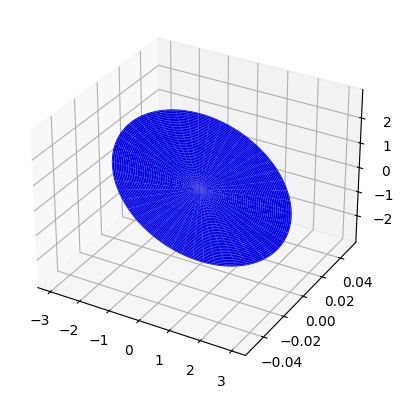

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y, Z = create_3d_disk([0,0,0],3,[0,1,0])
ax.plot_surface(X, Y, Z, color='b')

plt.show()

In [8]:
def sum_vectors_except_last(vector_dict):
    sum_vector = [0, 0, 0]
    keys = list(vector_dict.keys())
    for key in keys[:-1]:
        vector = vector_dict[key]
        for i in range(3):
            sum_vector[i] += vector[i]
    return sum_vector

In [9]:
def Show_all_Disks(V, R, N, r):
    N_Vec_Disk = {}
    Vec = {}
    Disk = {}
    Disk_centers = {}

    N_Vec_Disk[0] = (0,R,0)
    Vec[0] = V
    Disk[0] = create_3d_disk([0,0,0],r,(0,1,0))
    Disk_centers[0] = [0,0,0]

    for i in range(1, N):
        Vec[i] = Rotate_Vector_n_times(V, R, 2*i)
        N_Vec_Disk[i] = Rotate_Vector_n_times(V,R,2*i-1)
        Disk_centers[i] = sum_vectors_except_last(Vec)
        Disk[i] = create_3d_disk(Disk_centers[i],r,N_Vec_Disk[i])

    data = []

    for i in range(0,N):
        X, Y, Z = Disk[i]
        data.append(go.Surface(x=X, y=Y, z=Z, showscale=False))

    x_rods, y_rods, z_rods = zip(*Disk_centers.values())
    rods = go.Scatter3d(x=x_rods, y=y_rods, z=z_rods, mode='lines', line=dict(color='black', width=10))
    data.append(rods)

    layout = go.Layout(scene=dict(aspectmode='cube',
                                  xaxis=dict(range=[-1000, 1000], autorange=False),
                                  yaxis=dict(range=[-1000, 1000], autorange=False),
                                  zaxis=dict(range=[-1000, 1000], autorange=False)))

    fig = go.Figure(data=data, layout=layout)
    fig.show()


In [10]:
def Continuum_Robot_Simulator(r, l1, l2, l3, N):
    D, theta, phi, V = get_Vectors_and_Angles(r, l1, l2, l3, N)
    R = Get_Rotation_Matrix(V)
    Show_all_Disks(V, R, N, r)

In [11]:
def inverse_kinematics(theta, phi, Nodes, Length, radius):

    Nodes = Nodes - 1

    theta = math.radians(theta)
    phi = math.radians(phi)

    l_1 = Length - 2 * radius * np.cos(phi) * np.sin(theta / Nodes / 2)
    l_2 = Length - 2 * radius * np.cos(phi - 2/3 * np.pi) * np.sin(theta / Nodes / 2)
    l_3 = Length - 2 * radius * np.cos(phi - 4/3 * np.pi) * np.sin(theta / Nodes / 2)

    return l_1, l_2, l_3

In [22]:
inverse_kinematics(float(input("theta : ")),
                          float(input("phi : ")),
                          int(input("Spacing Disk의 개수 : ")),
                          float(input("Spacing Disk와 다음 Spacing Disk 사이의 길이 : ")),
                          float(input("Spacing Disk의 반지름 길이 : ")))

theta : 60
phi : 0
Spacing Disk의 개수 : 10
Spacing Disk와 다음 Spacing Disk 사이의 길이 : 10
Spacing Disk의 반지름 길이 : 5


(9.418551710895242, 10.29072414455238, 10.29072414455238)

In [13]:
Continuum_Robot_Simulator(float(input("Spacing Disk의 반지름 길이 : ")),
                          float(input("Spacing Disk와 다음 Spacing Disk 사이의 Tendon 길이 1 : ")),
                          float(input("Spacing Disk와 다음 Spacing Disk 사이의 Tendon 길이 2 : ")),
                          float(input("Spacing Disk와 다음 Spacing Disk 사이의 Tendon 길이 3 : ")),
                          int(input("Spacing Disk의 개수 : ")))

Spacing Disk의 반지름 길이 : 5
Spacing Disk와 다음 Spacing Disk 사이의 Tendon 길이 1 : 10.29072414455238
Spacing Disk와 다음 Spacing Disk 사이의 Tendon 길이 2 : 9.418551710895242
Spacing Disk와 다음 Spacing Disk 사이의 Tendon 길이 3 : 10.29072414455238
Spacing Disk의 개수 : 10


In [23]:
l, theta, phi, V= get_Vectors_and_Angles(float(input("Spacing Disk의 반지름 길이 : ")),
                          float(input("Spacing Disk와 다음 Spacing Disk 사이의 Tendon 길이 1 : ")),
                          float(input("Spacing Disk와 다음 Spacing Disk 사이의 Tendon 길이 2 : ")),
                          float(input("Spacing Disk와 다음 Spacing Disk 사이의 Tendon 길이 3 : ")),
                          int(input("Spacing Disk의 개수 : ")))

print(f"length : {l}")
print(f"theta : {np.degrees(theta)}")
print(f"phi : {np.degrees(phi)}")

Spacing Disk의 반지름 길이 : 5
Spacing Disk와 다음 Spacing Disk 사이의 Tendon 길이 1 : 9.418551710895242
Spacing Disk와 다음 Spacing Disk 사이의 Tendon 길이 2 : 10.29072414455238
Spacing Disk와 다음 Spacing Disk 사이의 Tendon 길이 3 : 10.29072414455238
Spacing Disk의 개수 : 10
length : 10.0
theta : 3.333333333333474
phi : 0.0


In [24]:
np.degrees(theta) * 18

60.00000000000253